In [1]:
from halotools.sim_manager import CachedHaloCatalog, FakeSim
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array,wp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count
import emcee
#import corner
#from Corrfunc.theory.wp import wp
import MCMC_data_file
from numpy.linalg import inv
import scipy.optimize as op
from scipy.stats import chi2
import scipy.stats as stats
import random
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from scipy.special import gamma
from scipy.stats import chisquare, gaussian_kde
from tabcorr import TabCorr
import numpy as np
from os import walk
import gc

In [2]:
fname = 'zehavi_smdpl_mvir_m21_tabcorr_2.h5'
wp_out_file = None#'zehavi_smdpl_mvir_m19_wp.npy'
dname ='zehavi_data_file_21'
param = 'combo'
threshold = -21

if '21' in dname:
    import zehavi_data_file_21
    wp_ng_vals = zehavi_data_file_21.get_wp()[0:12]
    bin_edges = zehavi_data_file_21.get_bins()[0:12]
    cov_matrix = zehavi_data_file_21.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

In [32]:

halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/smdpl.dat.smdpl2.hdf5',update_cached_fname = True)
halocat.redshift=0.
ht = halocat.halo_table
vmax_ml = 10**(np.log10(ht['halo_vmax'])*3.1069839419403174+5.015822745222037)
ht.add_column(vmax_ml, name='vmax_ml')

pi_max = 60.
Lbox = 400.

hmvir = halocat.halo_table['halo_mvir']
hvmax = halocat.halo_table['vmax_ml']


class TabNames(object):
    def __init__(self, f):
        self.f = f
        self.a = float(f[:-5].split('combo_a')[1])
        self.model_instance = _get_model_inst(self.a)

def _get_model_inst(a):
    print(threshold)
    halocat.halo_table.add_column((hmvir**a)*(hvmax**(1-a)),name='combo')

    cens_occ_model = Zheng07Cens(prim_haloprop_key = 'combo',
                                 threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'combo',
                                  modulate_with_cenocc=True,
                                  threshold=threshold)
    sats_prof_model = NFWPhaseSpace()

    model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                     centrals_profile = cens_prof_model,
                                     satellites_occupation = sats_occ_model,
                                     satellites_profile = sats_prof_model)
    del(halocat.halo_table['combo'])
    return model_instance

def _get_wp_ng(model_instance,f):
    ngals,wp = TabCorr.read('/Users/lmezini/Halo/tabcorr_tables/{}'.format(f)).predict(model_instance)
    return ngals,wp

_, _, filenames = next(walk('/Users/lmezini/Halo/tabcorr_tables/'))
tab_names = [TabNames(f) for f in filenames]
mod_inst = [TabNames(f).model_instance for f in filenames]
tab_names_dict = dict(zip(filenames, tab_names))
mod_names_dict = dict(zip(filenames, mod_inst))

gc.collect()

-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21
-21


45434

In [3]:
vmax_ml_param = np.array([11.55810335721463, 0.2862891204128461, 1.0338249930274372, 10.939403081698728, 12.764501065211025])
mvir_param = np.array([11.815352884373995, 0.8384788322140141, 0.9869191298112429, 10.770008287092582, 12.742632068811936])


In [4]:
vmax_ml_param**(1-0.5)*mvir_param**0.5

array([11.68602027,  0.48994629,  1.01009983, 10.85437524, 12.75356188])

0.0
0.0011601828666286892 0.00116
0.01
0.001159351063094189 0.00116
0.02
0.0011589276072287177 0.00116
0.03
0.001158582487265143 0.00116
0.04
0.0011581513885217719 0.00116
0.05
0.0011576959765003995 0.00116
0.06
0.0011573109390069132 0.00116
0.07
0.00115696703093245 0.00116
0.08
0.0011567212655567783 0.00116
0.09
0.0011563763642865232 0.00116
0.1
0.0011560812800534767 0.00116
0.11
0.0011557024456039506 0.00116
0.12
0.0011554193585414613 0.00116
0.13
0.0011551276845360406 0.00116
0.14
0.0011547983235489225 0.00116
0.15
0.0011545036936977996 0.00116
0.16
0.0011541650273830164 0.00116
0.17
0.0011538415603825705 0.00116
0.18
0.001153543615939707 0.00116
0.19
0.0011531784695021597 0.00116
0.2
0.0011530367772670288 0.00116
0.21
0.0011528349988886182 0.00116
0.22
0.0011526323437183964 0.00116
0.23
0.0011523578897372935 0.00116
0.24
0.0011521864112157203 0.00116
0.25
0.0011519911651631702 0.00116
0.26
0.0011517659437531547 0.00116
0.27
0.0011515800696877123 0.00116
0.28
0.001151318758397887 0.

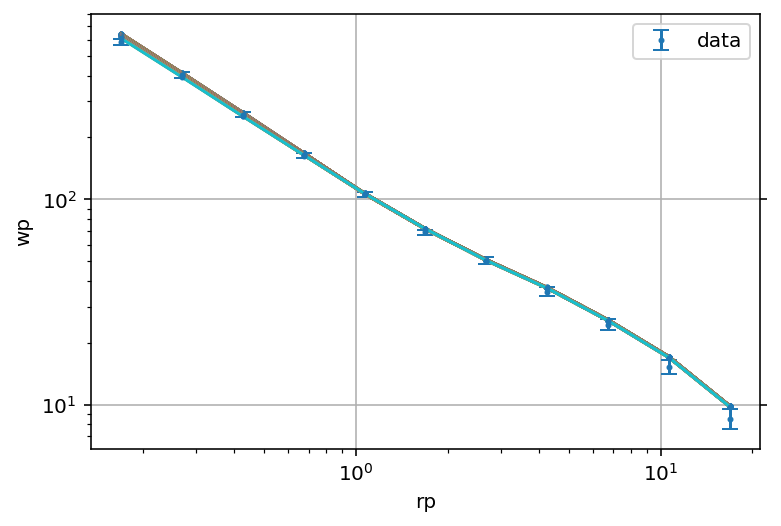

In [39]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
for i in range(0,100):
    a = i/100.
    print(a)
    if round(a,2) == 0.0:
        model_instance = mod_names_dict['smdpl_combo_a0.01.hdf5']
    elif round(a,2) == 0.9:
        model_instance = mod_names_dict['smdpl_combo_a0.91.hdf5']
    else:
        model_instance = mod_names_dict['smdpl_combo_a{}.hdf5'.format(round(a,2))]
        #cens_occ_model = Zheng07Cens(threshold=threshold)
        #cens_prof_model = TrivialPhaseSpace()

        #sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True,threshold=threshold)
        #sats_prof_model = NFWPhaseSpace()

        #model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
        #centrals_profile = cens_prof_model, satellites_occupation = sats_occ_model, 
        #satellites_profile = sats_prof_model)

    param_sampling = (vmax_ml_param**(1-a))*(mvir_param**a)
    model_instance.param_dict['logMmin'] = param_sampling[0]#Mmin_val[i]
    model_instance.param_dict['sigma_logM'] = param_sampling[1]#sigma_val[i]
    model_instance.param_dict['alpha'] = param_sampling[2]#alpha_val[i]
    model_instance.param_dict['logM0'] = param_sampling[3]#M0_val[i]
    model_instance.param_dict['logM1'] = param_sampling[4]#M1_val[i]
    
    if round(a,2) == 0.0:
        ngal,wp = _get_wp_ng(model_instance,'smdpl_combo_a0.01.hdf5')
    elif round(a,2) == 0.9:
        ngal,wp = _get_wp_ng(model_instance,'smdpl_combo_a0.91.hdf5')
    else:
        #ngal = tab_names_dict['smdpl_combo_a{}.hdf5'.format(round(a,2))].ngals
        #wp = tab_names_dict['smdpl_combo_a{}.hdf5'.format(round(a,2))].wp
        #ngal,wp = TabCorr.read('smdpl_halo_mvir.hdf5').predict(model_instance)
        ngal,wp = _get_wp_ng(model_instance,'smdpl_combo_a{}.hdf5'.format(round(a,2)))
    print(ngal, wp_ng_vals[0])
    plt.plot(bin_cen,wp,markersize=2)#,label='Vmax')
#plt.plot(bin_cen,oldfunc,label='Old Corrfunc')
#plt.title("")
plt.legend()
plt.ylabel('wp')
plt.xlabel('rp')
plt.tick_params(right=True)
plt.xscale('log')
plt.yscale('log')
plt.grid()
#plt.title(fname)
plt.savefig('a_vs_wp.png')

In [8]:
a = 1.
model_instance = _get_model_inst(a)
a1_ngals, a1_wp = TabCorr.read('/Users/lmezini/Halo/tabcorr_tables/{}'.format('smdpl_combo_a1.0.hdf5')).predict(model_instance)

-21


In [17]:
a1_wp

array([862.73867897, 534.00670408, 321.96897692, 194.60689733,
       120.13808987,  77.49532516,  53.09797376,  38.84055631,
        26.97306332,  17.83261174,  10.23139115])

In [12]:
"""
del(ht['vmax_ml'])
ht = halocat.halo_table
vmax_ml = 10**(np.log10(ht['halo_vmax'])*3.1069839419403174+5.015822745222037)
ht.add_column(vmax_ml, name='vmax_ml')
cens_occ_model = Zheng07Cens(prim_haloprop_key = 'vmax_ml',threshold=threshold)
cens_prof_model = TrivialPhaseSpace()

sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'vmax_ml', modulate_with_cenocc=True,threshold=threshold)
sats_prof_model = NFWPhaseSpace()

model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)
"""
cens_occ_model = Zheng07Cens(threshold=threshold)
cens_prof_model = TrivialPhaseSpace()

sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True,threshold=threshold)
sats_prof_model = NFWPhaseSpace()

model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)

In [14]:
ngals, wp = TabCorr.read('smdpl_halo_mvir.hdf5').predict(model_instance)

In [16]:
wp

array([864.54091796, 533.78543688, 321.94574182, 194.73829736,
       120.09692911,  77.42466483,  53.10866712,  38.83533469,
        26.97674812,  17.83838629,  10.2306561 ])

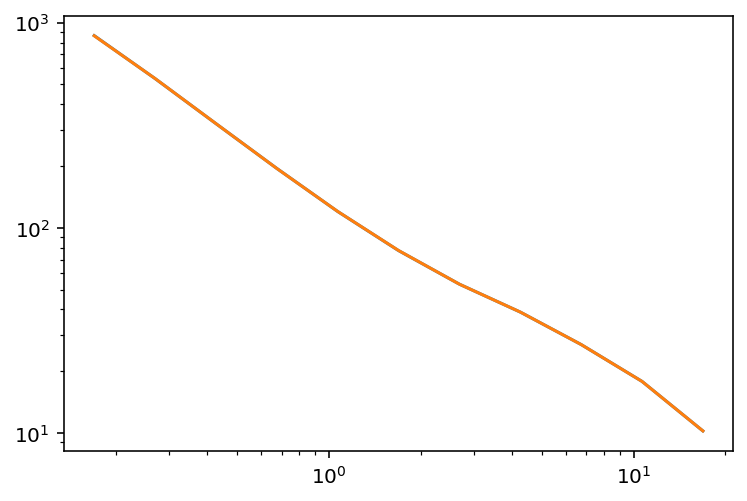

In [21]:
plt.loglog(bin_cen,wp)
plt.loglog(bin_cen,a1_wp)